<a href="https://colab.research.google.com/github/ioqfwfq/NMA_DL2021_Project/blob/main/PCA_FC_NMA_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Setup

In [1]:
# Imports
import torch
import numpy as np
import sklearn.decomposition as decomposition
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import scipy.stats as stats
import torch.utils
import torch.distributions
from matplotlib import pyplot as plt
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from tqdm import tqdm  # For a nice progress bar!

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---
# Load Data from Google Drive


In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Colab\ Notebooks/data/
!pwd
!dir

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/17xuhq9TF8GNhT9Xklt08_1TwyLvMiN_6/data
/content/drive/.shortcut-targets-by-id/17xuhq9TF8GNhT9Xklt08_1TwyLvMiN_6/data
data			 mouse1_day1_suqare2.mat  mouse1_day7_suqare1.mat
mouse1_day1_suqare1.csv  mouse1_day4_suqare1.csv  NeuronROIs.mat
mouse1_day1_suqare1.mat  mouse1_day4_suqare1.mat  ReadMe.txt
mouse1_day1_suqare2.csv  mouse1_day7_suqare1.csv


In [71]:
fn = 'mouse1_day1_suqare1.csv'
raw = pd.read_csv(fn, index_col=0)
ndata = raw.iloc[:,:-3].values
bdata = raw.iloc[:,-3:].values


In [5]:
ndata.shape

(7752, 505)

# Prep data: PCA

In [72]:
pca = decomposition.PCA(n_components=2)
pca.fit(ndata)
ndata = pca.transform(ndata)

# Build Dataset

In [73]:
#Transform and normalize the coordinates
x_coo = bdata[:,0]
y_coo = bdata[:,1]
# x_len = x_coo.max()-x_coo.min()
# y_len = y_coo.max()-y_coo.min()
# x_cen = (x_coo.max()+x_coo.min())*0.5
# y_cen = (y_coo.max()+y_coo.min())*0.5

# x_coo_nor = (x_coo-x_cen)/(x_len*0.5) # range [-1, 1]
# y_coo_nor = (y_coo-y_cen)/(y_len*0.5) 

# Find inside points
inside = np.zeros_like(bdata[:,1],dtype=bool)
for i in range(len(x_coo)):
  inside[i] = abs(x_coo[i]-32.5)<12.5 and abs(y_coo[i]-52.5)<12.5
ndata = ndata[inside]
bdata = bdata[inside]
x_coo = bdata[:,0]
y_coo = bdata[:,1]

In [74]:
# Make labels
labels = np.zeros_like(bdata[:,1])
labels_x = np.ceil(x_coo/5)-5
labels_x = labels_x.astype(int)
labels_y = np.ceil(y_coo/5)-9
labels_y = labels_y.astype(int)
num_classes = len(np.unique(labels_x)) * len(np.unique(labels_y))
label_list = np.linspace(0,num_classes-1,num_classes).reshape([len(np.unique(labels_x)),len(np.unique(labels_y))])

for i in range(len(labels)):
  labels[i] = label_list[labels_x[i],labels_y[i]]

In [75]:
# Make Dataloader
tensor_input = torch.Tensor(ndata)
tensor_label = torch.Tensor(labels)

my_dataset = TensorDataset(tensor_input,tensor_label) # create dateset

dataset_size = len(my_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = DataLoader(my_dataset,
                          batch_size=batch_size,
                          sampler=train_sampler)
valid_loader = DataLoader(my_dataset,
                          batch_size=batch_size,
                          sampler=valid_sampler)

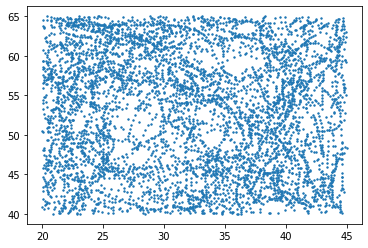

In [21]:
plt.scatter(x_coo[train_indices],y_coo[train_indices], s=2)

In [22]:
# debug
batch_test = next(iter(train_loader))
na, label_test = batch_test

print('types:', type(na), type(label_test))
print('shapes:', na.shape, label_test)

types: <class 'torch.Tensor'> <class 'torch.Tensor'>
shapes: torch.Size([64, 100]) tensor([15., 10.,  1., 14.,  5., 11., 15., 24.,  1.,  4.,  4.,  7., 22., 15.,
         5., 10., 12.,  4., 15.,  2., 14., 19., 22., 19., 14., 15.,  9., 17.,
         4.,  9., 15., 12.,  2., 23., 19.,  9., 23., 24., 14.,  2., 21.,  0.,
        16., 24.,  0., 22., 14., 13.,  4., 12., 17.,  2., 14., 16., 19.,  7.,
        22.,  8., 18., 19., 18., 17.,  8.,  8.])


---
# NN logistic

In [76]:
# Hyperparameters
input_size = ndata.shape[1]
hidden_size = 256
num_layers = 2
learning_rate = 0.005
batch_size = 64
num_epochs = 100
validation_split = .2

In [77]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        # self.fc1 = nn.Linear(input_size, num_classes)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x = self.fc1(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [78]:
# Initialize network
model = NN(input_size=input_size, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [79]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (tensor_input, tensor_label) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = tensor_input.to(device=device)
        targets = tensor_label.to(device=device)

        # Get to correct shape
        data = data.reshape(data.shape[0], -1)

        # forward
        scores = model(data)
        loss = criterion(scores, targets.long())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

100%|██████████| 83/83 [00:00<00:00, 583.83it/s]


In [80]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct/num_samples


print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(valid_loader, model)*100:.2f}")

Accuracy on training set: 15.81
Accuracy on test set: 14.71
